<a href="https://colab.research.google.com/github/KrpesFilip/NLP/blob/main/NLP_LV3_FK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LV3 - Klasifikacija teksta pomoću strojnog učenja



## Ciljevi laboratorijske vježbe:


*   Pripremiti označene skupove podataka za klasifikaciju teksta
*   Trenirati klasifikator
*   Evaluirati performanse klasifikatora (točnost, preciznost, odziv)



## 1. Instalacija biblioteka

In [1]:
from google.colab import files
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

## 2. Učitavanje dataseta Coronavirus tweets NLP - Text Classification

Potrebno je preuzeti javni dataset s platforme Kaggle. Kako bi preuzimanje bilo uspješno, potrebno je preuzeti datoteku `kaggle.json` sa svog Kaggle korisničkog profila i uploadati ju prilikom izvođenja sljedećeg programskog koda. Moguće je i preuzeti dataset i prenijeti ga u Google Colab ručno. Dataset možete preuzeti na [linku](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).



In [ ]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification
License(s): copyright-authors
covid-19-nlp-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip covid-19-nlp-text-classification.zip -d covid_dataset

# Ovaj dataset dolazi kodiran u ISO-8859-1 (Latin-1), pa je potrebno specificirati encoding parametar
train = pd.read_csv("covid_dataset/Corona_NLP_train.csv", encoding="latin1")
test = pd.read_csv("covid_dataset/Corona_NLP_test.csv", encoding="latin1")

train.head()

Archive:  covid-19-nlp-text-classification.zip
  inflating: covid_dataset/Corona_NLP_test.csv  
  inflating: covid_dataset/Corona_NLP_train.csv  


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 3. Priprema podataka



### a) Odabir značajki

In [3]:
selected_features_train = train[['OriginalTweet', 'Sentiment']]
selected_features_test = test[['OriginalTweet', 'Sentiment']]

### b) Provjera nedostajućih vrijednosti

In [4]:
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Budući da stupac Location neće biti korišten pri treniranju modela, nedostajuće vrijednosti se mogu zanemariti.

In [5]:
# ZADATAK: Provjerite nedostajuće vrijednosti u testnom skupu te riješite na prikladan način ukoliko ih ima
print(selected_features_test.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

3798
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Broj ponavljanja svake kategorije:
Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


/tmp/ipython-input-1935638248.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


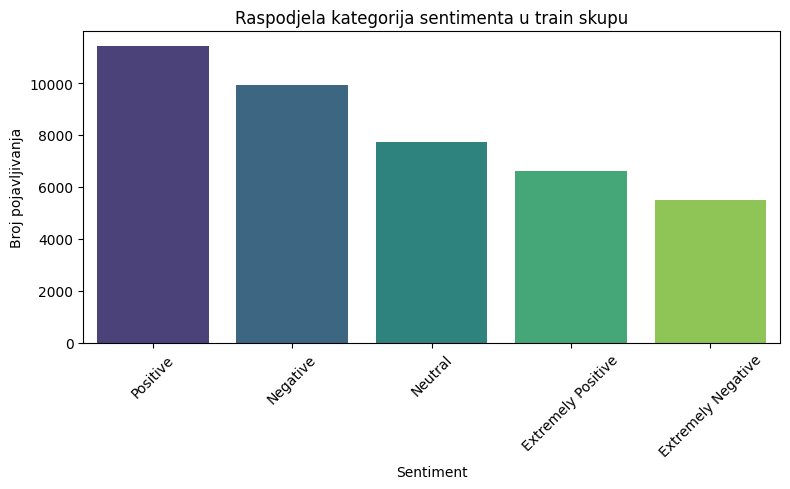

In [6]:
#ZADATAK: Provjerite broj ponavljanja svake od kategorija tweetova te ih prikžite na grafu koristeći prikladne biblioteke

sentiment_counts = selected_features_train['Sentiment'].value_counts()

print("Broj ponavljanja svake kategorije:")
print(sentiment_counts)

plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

plt.title("Raspodjela kategorija sentimenta u train skupu")
plt.xlabel("Sentiment")
plt.ylabel("Broj pojavljivanja")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Broj primjeraka u svakoj klasi nakon mapiranja:
Sentiment
Positive    18046
Negative    15398
Neutral      7713
Name: count, dtype: int64


/tmp/ipython-input-1805598223.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
/tmp/ipython-input-1805598223.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)
/tmp/ipython-input-1805598223.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

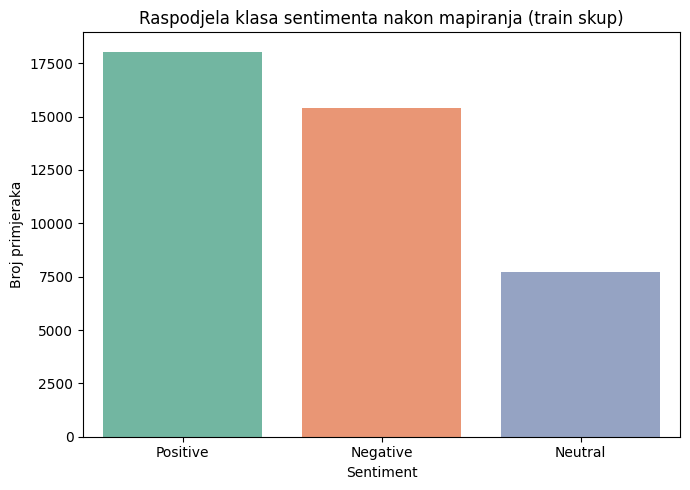

In [7]:
mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)

#ZADATAK: Prikažite broj primjeraka u svakoj klasi nakon mapiranja

mapped_counts = selected_features_train['Sentiment'].value_counts()

print("Broj primjeraka u svakoj klasi nakon mapiranja:")
print(mapped_counts)


plt.figure(figsize=(7,5))
sns.barplot(x=mapped_counts.index, y=mapped_counts.values, palette="Set2")

plt.title("Raspodjela klasa sentimenta nakon mapiranja (train skup)")
plt.xlabel("Sentiment")
plt.ylabel("Broj primjeraka")
plt.tight_layout()
plt.show()


### c) Lematizacija i čišćenje teksta

In [8]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [26]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):

    tokens = word_tokenize(text.lower())

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [17]:
def clean_text(text):
    if text is None:
        return ""

    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [27]:
selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
selected_features_test['clean_tweet'] = selected_features_test['OriginalTweet'].apply(lemmatize_text).apply(clean_text)

/tmp/ipython-input-1869587339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
/tmp/ipython-input-1869587339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_test['clean_tweet'] = selected_features_test['OriginalTweet'].apply(lemmatize_text).apply(clean_text)


### d) Pretvaranje teksta u vektore značajki (TF-IDF)

TF-IDF (Term Frequency–Inverse Document Frequency) je statistička metoda koja se koristi u obradi prirodnog jezika i pretraživanju informacija za procjenu koliko je određena riječ važna za jedan dokument u odnosu na veću zbirku dokumenata. TF-IDF kombinira dvije komponente:
1. Frekvencija pojma (TF): Mjeri koliko se puta riječ pojavljuje u dokumentu. Veća učestalost sugerira veću važnost. Ako se neki pojam često pojavljuje u dokumentu, vjerojatno je relevantan za sadržaj tog dokumenta.
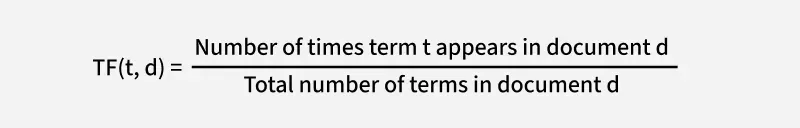

2. Obrnuta frekvencija dokumenta (IDF): Smanjuje težinu uobičajenih riječi koje se pojavljuju u više dokumenata, dok povećava težinu rijetkih riječi. Ako se pojam pojavljuje u manjem broju dokumenata, veća je vjerojatnost da je značajan i specifičan.
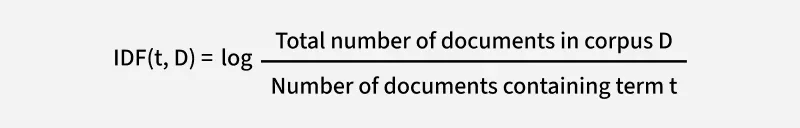

Ova ravnoteža omogućuje TF-IDF-u da istakne pojmove koji su i učestali unutar određenog dokumenta i prepoznatljivi u odnosu na ostatak zbirke dokumenata, što ga čini korisnim alatom za zadatke poput rangiranja pretraživanja, klasifikacije teksta i izdvajanja ključnih riječi.

In [29]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(selected_features_train['clean_tweet'])
#ZADATAK: Transformirati očišćene tekstualne tweetove u numeričku TF-IDF reprezentaciju na testnom skupu.
X_test = tfidf.transform(selected_features_test['clean_tweet'])

print("TRAIN HEAD:")
print(selected_features_train['clean_tweet'].head(), "\n")

print("TEST HEAD:")
print(selected_features_test['clean_tweet'].head())

TRAIN HEAD:
0    menyrbie philgahan chrisitv http tcoifzfanpa a...
1    advice talk to your neighbour family to exchan...
2    coronavirus australia woolworth to give elderl...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: clean_tweet, dtype: object 

TEST HEAD:
0    trending new yorkers encounter empty supermark...
1    when i could nt find hand sanitizer at fred me...
2    find out how you can protect yourself and love...
3    panic buying hit newyork city a anxious shoppe...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: clean_tweet, dtype: object


### e) Enkodiranje oznaka

In [30]:
le = LabelEncoder()

print(selected_features_train['Sentiment'].unique())

y_train = le.fit_transform(selected_features_train['Sentiment'])
y_test = le.transform(selected_features_test['Sentiment'])

y_train = pd.DataFrame(y_train, columns=['Sentiment'])
y_test = pd.DataFrame(y_test, columns=['Sentiment'])
y_train.head()

['Neutral' 'Positive' 'Negative']


,Sentiment
0,1
1,2
2,2
3,2
4,0


## 4. Treniranje modela - Naive Bayes

In [31]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.68010321854413


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [32]:
model = MultinomialNB(alpha = 0.1)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.1)

## 5. Evaluacija performansi

In [33]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.73      0.73      1633
     Neutral       0.62      0.20      0.31       619
    Positive       0.64      0.81      0.72      1546

    accuracy                           0.68      3798
   macro avg       0.66      0.58      0.58      3798
weighted avg       0.67      0.68      0.65      3798

Confusion Matrix:

[[1186   50  397]
 [ 186  126  307]
 [ 266   27 1253]]


## ZADATAK:
Trenirati model koristeći SVM i usporediti performanse s Naive Bayes-om.

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best NB alpha:", grid.best_params_)
print("Best NB cross-val accuracy:", grid.best_score_)

nb_model = MultinomialNB(alpha=grid.best_params_['alpha'])
nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

print("\n===== NAIVE BAYES REPORT =====\n")
print(classification_report(y_test, nb_pred, target_names=le.classes_))
print("Confusion Matrix (NB):\n")
print(confusion_matrix(y_test, nb_pred))


param_grid_svm = {'C': [0.1, 0.5, 1.0, 2.0]}

svm_grid = GridSearchCV(LinearSVC(), param_grid_svm, cv=skf, scoring='accuracy')
svm_grid.fit(X_train, y_train.values.ravel())

print("\nBest SVM C:", svm_grid.best_params_)
print("Best SVM cross-val accuracy:", svm_grid.best_score_)

svm_model = LinearSVC(C=svm_grid.best_params_['C'])
svm_model.fit(X_train, y_train.values.ravel())

svm_pred = svm_model.predict(X_test)

print("\n===== SVM REPORT =====\n")
print(classification_report(y_test, svm_pred, target_names=le.classes_))
print("Confusion Matrix (SVM):\n")
print(confusion_matrix(y_test, svm_pred))

nb_acc = accuracy_score(y_test, nb_pred)
svm_acc = accuracy_score(y_test, svm_pred)

print("\n===== USPOREDBA MODELA =====")
print(f"Naive Bayes Accuracy: {nb_acc:.4f}")
print(f"SVM Accuracy:         {svm_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best NB alpha: {'alpha': 0.1}
Best NB cross-val accuracy: 0.68010321854413

===== NAIVE BAYES REPORT =====

              precision    recall  f1-score   support

    Negative       0.72      0.73      0.73      1633
     Neutral       0.62      0.20      0.31       619
    Positive       0.64      0.81      0.72      1546

    accuracy                           0.68      3798
   macro avg       0.66      0.58      0.58      3798
weighted avg       0.67      0.68      0.65      3798

Confusion Matrix (NB):

[[1186   50  397]
 [ 186  126  307]
 [ 266   27 1253]]

Best SVM C: {'C': 0.5}
Best SVM cross-val accuracy: 0.7968269356443481

===== SVM REPORT =====

              precision    recall  f1-score   support

    Negative       0.82      0.79      0.80      1633
     Neutral       0.69      0.65      0.67       619
    Positive       0.79      0.84      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.77      0.76      0.76      3798
weighted 

# Zadatak – samostalan rad na datasetu

### U ovom zadatku studenti će sami proći cijeli proces klasifikacije teksta koristeći metode strojnog učenja – od pripreme podataka do treniranja i usporedbe različitih modela.

Cilj je klasificirati opise proizvoda iz e-trgovine u jednu od četiri kategorije (Electronics, Household, Books, Clothing & Accessories).

### Koraci zadatka:

1. **Pregled dataseta**  
   - Preuzmite dataset „E-commerce Text Classification“ s Kaggle-a:  
     https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification  
   - Učitajte ga u Colab (npr. pomoću `pd.read_csv`)  
   - Prikažite osnovne informacije o datasetu

2. **Odabir značajki i čišćenje podataka**  
   - Provjerite i obradite nedostajuće vrijednosti
   - Uklonite duplikate ako postoje  
   - Po potrebi uravnotežite dataset (npr. undersampling/oversampling) – nije obavezno, ali je plus

3. **Predobrada teksta (čišćenje i lematizacija)**  
   - Pretvorite tekst u mala slova  
   - Uklonite HTML tagove, URL-ove, interpunkciju, brojeve, specijalne znakove  
   - Uklonite stop-riječi  
   - Provedite lematizaciju

4. **Pretvaranje teksta u vektore značajki**  
     - `TfidfVectorizer`
   - Podijelite podatke na train/test skup (80/20 ili 75/25)

5. **Enkodiranje oznaka (labela)**  
   - Pretvorite tekstualne kategorije u brojčane pomoću `LabelEncoder` ili `OneHotEncoder` (ovisno o modelu)

6. **Treniranje i usporedba modela**  
   
   
   Za svaki model:
   - Naučite model na trening skupu
   - Izmjerite performanse na test skupu: **accuracy, precision, recall, F1-score**
   - Nacrtajte **confusion matrix** i **classification report**
   - Ako stignete: Podesite hiperparametre (barem `GridSearchCV` ili `RandomizedSearchCV` na 2–3 parametra) za bolje rezultate

7. **Vizualizacija rezultata**  
   - Usporedite dva (ili više) modela u tablici i stupčastim grafom (accuracy, F1-score)
   
   - Ako koristite TF-IDF, pokažite 10–20 riječi s najvećim TF-IDF težinama po klasi (Iz riječi biste trebali zaključiti o kojoj klasi se radi)

8. **Zaključak i komentar rezultata**  
   - Koji model je bio bolji i zašto?
   - Koje su prednosti i nedostaci pristupa koje ste koristili?
   - Što biste još mogli isprobati da poboljšate rezultat (ideje za daljnje eksperimente)?
   - Koliko je predobrada teksta utjecala na performanse?


In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhshahane/ecommerce-text-classification")

print("Path to dataset files:", path)

100%|██████████| 7.86M/7.86M [00:01<00:00, 5.61MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saurabhshahane/ecommerce-text-classification/versions/76


In [38]:
import pandas as pd

raw = pd.read_csv(path + "/ecommerceDataset.csv", header=None)
raw.head()


,0,1
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [39]:
df = pd.read_csv(path + "/ecommerceDataset.csv", header=None, names=["Category", "Description"])
df.head()


,Category,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


Prvih 5 redova:


,Category,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...



Info o datasetu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     50425 non-null  object
 1   Description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB
None

Broj zapisa po klasi:
Category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64

Nedostajuće vrijednosti:
Category       0
Description    1
dtype: int64

Broj duplikata: 22622


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Primjer očišćenog teksta:


,Description,clean_text
0,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch x inch sp...
2,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...
3,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...
4,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...



Dimenzije TF-IDF matrice: (22241, 5000)

===== NAIVE BAYES =====

                        precision    recall  f1-score   support

                 Books       0.97      0.88      0.92      1251
Clothing & Accessories       0.95      0.97      0.96      1135
           Electronics       0.92      0.91      0.92      1062
             Household       0.91      0.95      0.93      2113

              accuracy                           0.93      5561
             macro avg       0.94      0.93      0.93      5561
          weighted avg       0.93      0.93      0.93      5561

Confusion Matrix (NB):

[[1099   24   26  102]
 [   3 1102    5   25]
 [  16    3  968   75]
 [  18   37   54 2004]]

===== SVM =====

                        precision    recall  f1-score   support

                 Books       0.95      0.94      0.94      1251
Clothing & Accessories       0.98      0.98      0.98      1135
           Electronics       0.95      0.92      0.94      1062
             Household    

/tmp/ipython-input-2089514965.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Naive Bayes", "SVM"], y=[nb_acc, svm_acc], palette="viridis")


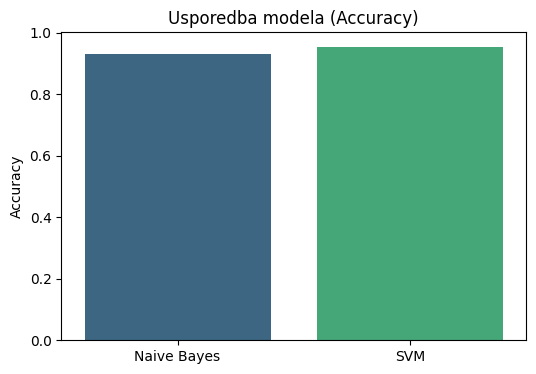


Top riječi za klasu: Books
['book', 'author', 'review', 'university', 'life', 'new', 'world', 'student', 'time', 'story', 'india', 'year', 'exam', 'science', 'one']

Top riječi za klasu: Clothing & Accessories
['cotton', 'woman', 'men', 'wear', 'girl', 'shirt', 'fit', 'boy', 'fabric', 'look', 'size', 'made', 'pack', 'sock', 'soft']

Top riječi za klasu: Electronics
['usb', 'camera', 'gb', 'cable', 'black', 'mm', 'speaker', 'bluetooth', 'phone', 'device', 'laptop', 'audio', 'card', 'wireless', 'power']

Top riječi za klasu: Household
['set', 'steel', 'home', 'cm', 'product', 'stainless', 'stainless steel', 'color', 'table', 'use', 'easy', 'kitchen', 'size', 'inch', 'water']


In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#df = pd.read_csv(path + "/ecommerceDataset.csv")

print("Prvih 5 redova:")
display(df.head())

print("\nInfo o datasetu:")
print(df.info())

print("\nBroj zapisa po klasi:")
print(df['Category'].value_counts())

print("\nNedostajuće vrijednosti:")
print(df.isnull().sum())

df.dropna(inplace=True)

print("\nBroj duplikata:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)           # HTML
    text = re.sub(r'http\S+|www.\S+', ' ', text) # URLs
    text = re.sub(r'[^a-z\s]', ' ', text)        # Non-letters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['clean_text'] = df['Description'].apply(preprocess)

print("\nPrimjer očišćenog teksta:")
display(df[['Description', 'clean_text']].head())


from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("\nDimenzije TF-IDF matrice:", X_train_tfidf.shape)



from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train_enc)
nb_pred = nb.predict(X_test_tfidf)


svm = LinearSVC(C=1.0)
svm.fit(X_train_tfidf, y_train_enc)
svm_pred = svm.predict(X_test_tfidf)


print("\n===== NAIVE BAYES =====\n")
print(classification_report(y_test_enc, nb_pred, target_names=le.classes_))
print("Confusion Matrix (NB):\n")
print(confusion_matrix(y_test_enc, nb_pred))

print("\n===== SVM =====\n")
print(classification_report(y_test_enc, svm_pred, target_names=le.classes_))
print("Confusion Matrix (SVM):\n")
print(confusion_matrix(y_test_enc, svm_pred))


nb_acc = accuracy_score(y_test_enc, nb_pred)
svm_acc = accuracy_score(y_test_enc, svm_pred)

print("\nUSPOREDBA:")
print(f"Naive Bayes accuracy: {nb_acc:.4f}")
print(f"SVM accuracy:         {svm_acc:.4f}")



plt.figure(figsize=(6,4))
sns.barplot(x=["Naive Bayes", "SVM"], y=[nb_acc, svm_acc], palette="viridis")
plt.title("Usporedba modela (Accuracy)")
plt.ylabel("Accuracy")
plt.show()



def top_tfidf_words(class_id, top_n=15):
    class_tfidf_means = X_train_tfidf[y_train_enc == class_id].mean(axis=0)
    values = class_tfidf_means.A1
    top_indices = values.argsort()[::-1][:top_n]
    words = [tfidf.get_feature_names_out()[i] for i in top_indices]
    return words

for i, label in enumerate(le.classes_):
    print(f"\nTop riječi za klasu: {label}")
    print(top_tfidf_words(i))


SVM se u ovom zadatku pokazao boljim modelom od Naive Bayes-a jer je postigao višu ukupnu točnost (95.4% naspram 93.0%) i bolji F1-score u većini kategorija; to je očekivano jer LinearSVC obično bolje razdvaja tekstualne podatke u visoko-dimenzijskim TF-IDF vektorima, dok Naive Bayes pretpostavlja nezavisnost značajki i time gubi dio informacija. Prednost korištenog pristupa je što je jednostavan, vrlo učinkovit i skalabilan: TF-IDF dobro hvata najinformativnije riječi, a modeli poput NB i SVM-a su brzi i stabilni. Nedostatak je što se oslanjamo samo na površinske karakteristike teksta — gubimo semantičke odnose, kontekst i više-riječne izraze koji nisu formalno modelirani. Za poboljšanje rezultata mogli bi se isprobati: Word Embeddings, moderne duboke arhitekture, selekcija značajki, balansiranje podataka, proširenje modela hiperparametrima. Predobrada teksta imala je velik utjecaj na performanse jer je čišćenje šuma i lematizacija značajno poboljšala kvalitetu TF-IDF vektora, što je omogućilo modelima da fokusiraju težine na prave domenske termine što se jasno vidi u top TF-IDF riječima koje vrlo precizno opisuju svaku kategoriju.